# Project on Classification
## Studying customers whose loan is already paid off or defaulted and build a classification model


In [658]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [659]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-03-17 22:57:42--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.09s   

2022-03-17 22:57:42 (245 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [660]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [661]:
df.shape

(346, 10)

### Convert to date time object


In [662]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [663]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [664]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



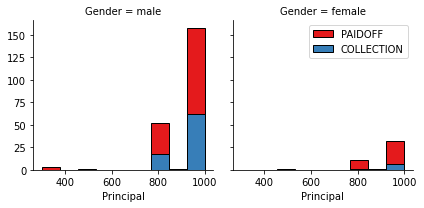

In [665]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

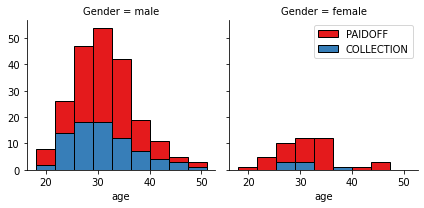

In [666]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

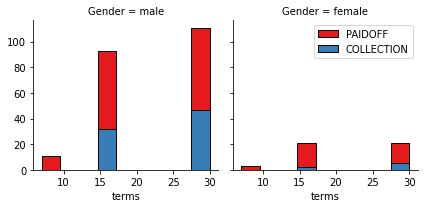

In [667]:

bins = np.linspace(df.terms.min(), df.terms.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'terms', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


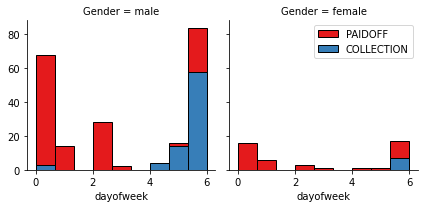

In [668]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [669]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [670]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [671]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [672]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [673]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [674]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [675]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [676]:
df['loan_status']=df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'],value=[0,1])

What are our lables?


In [677]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

# Train Test Split

In [678]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=42)

In [679]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(231, 8) (231,)
(115, 8) (115,)


## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [680]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_norm=scaler.fit_transform(X_train)
X_test_norm=scaler.transform(X_test)

In [681]:
values, counts = np.unique(y_train, return_counts=True)
print(values,counts)


[0 1] [ 60 171]


# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [682]:
from sklearn.neighbors import KNeighborsClassifier

In [683]:
k=17
knn=KNeighborsClassifier(n_neighbors=k)

knn.fit(X_train_norm,y_train)

KNeighborsClassifier(n_neighbors=17)

In [684]:
y_pred=knn.predict(X_test_norm)

In [685]:
from sklearn.metrics import accuracy_score

print("Train set accuracy is ",accuracy_score(y_train,knn.predict(X_train_norm)))
print("Test set accuracy is ",accuracy_score(y_test,y_pred))

Train set accuracy is  0.7748917748917749
Test set accuracy is  0.7043478260869566


In [686]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_norm,y_train)
    ypred=neigh.predict(X_test_norm)
    mean_acc[n-1] = accuracy_score(y_test, ypred)

    
    std_acc[n-1]=np.std(ypred==y_test)/np.sqrt(ypred.shape[0])

mean_acc

array([0.69565217, 0.6       , 0.70434783, 0.64347826, 0.68695652,
       0.68695652, 0.66086957, 0.69565217, 0.65217391, 0.65217391,
       0.66086957, 0.66086957, 0.66956522, 0.66086957, 0.66956522,
       0.68695652, 0.70434783, 0.67826087, 0.69565217])

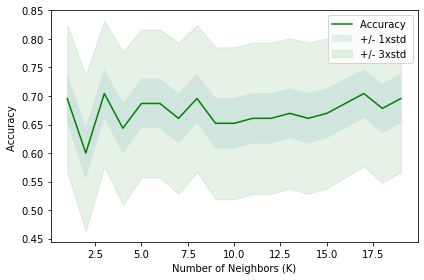

In [687]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Decision Tree


In [688]:
FeatureDT = df[['Principal','terms','age','Gender','weekend']]
FeatureDT

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1
...,...,...,...,...,...
341,800,15,32,0,1
342,1000,30,25,0,1
343,800,15,39,0,0
344,1000,30,28,0,0


In [689]:

FeatureDT = pd.concat([FeatureDT,pd.get_dummies(df['education'])], axis=1)
FeatureDT.drop(['Master or Above'], axis = 1,inplace=True)
FeatureDT.drop_duplicates()
FeatureDT.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [690]:
X_train_DT=FeatureDT

In [691]:
from sklearn.model_selection import train_test_split

X_traindt, X_testdt, y_traindt, y_testdt=train_test_split(X_train_DT, y, test_size=0.33, random_state=42)


In [692]:
print(X_traindt.shape,X_testdt.shape)

(231, 8) (115, 8)


In [693]:
scaler1=StandardScaler()
X_traindt_norm=scaler1.fit_transform(X_traindt)
X_testdt_norm=scaler1.transform(X_testdt)

In [694]:
from sklearn.tree import DecisionTreeClassifier
md=40
mean_acc1 = np.zeros((md-1))
std_acc = np.zeros((md-1))

for n in range(1,md):
    
    #Train Model and Predict  
    tree = DecisionTreeClassifier(criterion='entropy',max_depth=n).fit(X_traindt_norm,y_train)
    ypred_tree=tree.predict(X_testdt_norm)
    mean_acc1[n-1] = accuracy_score(y_testdt, ypred_tree)

    
    std_acc[n-1]=np.std(ypred_tree==y_testdt)/np.sqrt(ypred_tree.shape[0])

mean_acc1

array([0.77391304, 0.77391304, 0.63478261, 0.63478261, 0.63478261,
       0.64347826, 0.66086957, 0.65217391, 0.63478261, 0.62608696,
       0.63478261, 0.64347826, 0.62608696, 0.62608696, 0.62608696,
       0.62608696, 0.62608696, 0.62608696, 0.62608696, 0.62608696,
       0.62608696, 0.62608696, 0.62608696, 0.62608696, 0.62608696,
       0.62608696, 0.62608696, 0.62608696, 0.62608696, 0.62608696,
       0.62608696, 0.62608696, 0.62608696, 0.62608696, 0.62608696,
       0.62608696, 0.62608696, 0.62608696, 0.62608696])

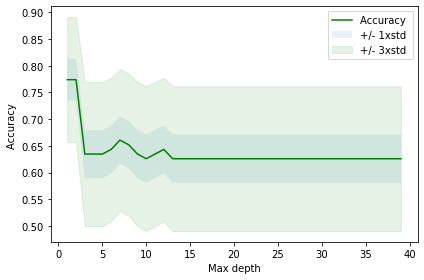

In [695]:
plt.plot(range(1,md),mean_acc1,'g')
plt.fill_between(range(1,md),mean_acc1 - 1 * std_acc,mean_acc1 + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,md),mean_acc1 - 3 * std_acc,mean_acc1 + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max depth')
plt.tight_layout()
plt.show()

In [696]:
print( "The best accuracy was with", mean_acc1.max(), "with max depth=", mean_acc1.argmax()+1)

The best accuracy was with 0.7739130434782608 with max depth= 1


In [697]:
DT=DecisionTreeClassifier(criterion='entropy',max_depth=10)

In [698]:
DT.fit(X_traindt_norm,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [699]:
y_pred_DT=DT.predict(X_testdt_norm)

In [700]:
print("Train set accuracy is ",accuracy_score(y_train,DT.predict(X_traindt_norm)))
print("Test set accuracy is ",accuracy_score(y_test,y_pred_DT))

Train set accuracy is  0.9004329004329005
Test set accuracy is  0.6260869565217392


# Support Vector Machine


In [701]:
FeatureSVM = df[['Principal','terms','age','Gender','weekend']]
FeatureSVM

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1
...,...,...,...,...,...
341,800,15,32,0,1
342,1000,30,25,0,1
343,800,15,39,0,0
344,1000,30,28,0,0


In [702]:
FeatureSVM = pd.concat([FeatureSVM,pd.get_dummies(df['education'])], axis=1)
FeatureSVM.drop(['Master or Above'], axis = 1,inplace=True)
FeatureSVM.drop_duplicates()
FeatureSVM.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [703]:
X_train_SVM=FeatureSVM

In [704]:
from sklearn.model_selection import train_test_split

X_trainsvm, X_testsvm, y_trainsvm, y_testsvm=train_test_split(X_train_SVM, y, test_size=0.33, random_state=42)

In [705]:
print(X_trainsvm.shape,X_testsvm.shape)

(231, 8) (115, 8)


In [706]:
scaler2=StandardScaler()
X_trainsvm_norm=scaler2.fit_transform(X_trainsvm)
X_testsvm_norm=scaler2.transform(X_testsvm)

In [707]:
from sklearn.svm import SVC

SVM=SVC(kernel='rbf')

SVM.fit(X_trainsvm_norm,y_train)

SVC()

In [708]:
y_pred_SVM=SVM.predict(X_testsvm_norm)

In [709]:
print("Train set accuracy for SVM is ",accuracy_score(y_train,SVM.predict(X_trainsvm_norm)))
print("Test set accuracy for SVM is ",accuracy_score(y_test,y_pred_SVM))

Train set accuracy for SVM is  0.8008658008658008
Test set accuracy for SVM is  0.6869565217391305


# Logistic Regression


In [758]:
FeatureLR = df[['Principal','terms','age','Gender','weekend']]
FeatureLR

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1
...,...,...,...,...,...
341,800,15,32,0,1
342,1000,30,25,0,1
343,800,15,39,0,0
344,1000,30,28,0,0


In [759]:
FeatureLR = pd.concat([FeatureLR,pd.get_dummies(df['education'])], axis=1)
FeatureLR.drop(['Master or Above'], axis = 1,inplace=True)
FeatureLR.drop_duplicates()
FeatureLR.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [760]:
X_train_LR=FeatureLR

In [761]:
from sklearn.model_selection import train_test_split

X_trainLR, X_testLR, y_trainLR, y_testLR=train_test_split(X_train_LR, y, test_size=0.33, random_state=42)

In [762]:
print(X_trainLR.shape,X_testLR.shape)

(231, 8) (115, 8)


In [763]:
scaler3=StandardScaler()
X_trainLR_norm=scaler3.fit_transform(X_trainLR)
X_testLR_norm=scaler3.transform(X_testLR)

In [764]:
from sklearn.linear_model import LogisticRegression

LR=LogisticRegression(C=0.01,solver='lbfgs')

LR.fit(X_trainLR_norm,y_train)

LogisticRegression(C=0.01)

In [765]:
y_pred_LR=LR.predict(X_testLR_norm)

In [766]:
print("Train set accuracy for Logreg is ",accuracy_score(y_train,LR.predict(X_trainLR_norm)))
print("Test set accuracy for Logreg is ",accuracy_score(y_test,y_pred_LR))

Train set accuracy for Logreg is  0.7402597402597403
Test set accuracy for Logreg is  0.7739130434782608


# Model Evaluation using Test set


In [719]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [720]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-03-17 22:58:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-03-17 22:58:19 (32.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [721]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [722]:
test_df.shape

(54, 10)

In [723]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [724]:
test_df['dayofweek']=test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [725]:
test_df['loan_status'].replace(to_replace=['COLLECTION','PAIDOFF'],value=[0,1],inplace=True)

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,1,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,1,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,1,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,1,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,1,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [726]:
X_test_new=test_df[['Principal','terms','age','Gender','weekend','education']]

In [727]:
X_test_new=pd.concat([X_test_new,pd.get_dummies(X_test_new['education'])],axis=1)
X_test_new.drop(['education','Master or Above'],axis=1,inplace=True)


In [728]:
y_test_new=test_df['loan_status']
y_test_new.shape

(54,)

In [729]:
X_test_new['Gender'].replace(to_replace=['male','female'],value=[0,1],inplace=True)

X_test_new.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [730]:
X_test_new.shape

(54, 8)

# Load Test set for evaluation

KNN 

In [731]:
X_test_new_norm=scaler.transform(X_test_new)

In [732]:
y_pred_knn_new=knn.predict(X_test_new_norm)

In [733]:
print("Jaccard score for KNN is ",jaccard_score(y_test_new,y_pred_knn_new))
print("F1 score for KNN is ",f1_score(y_test_new,y_pred_knn_new, average='weighted'))


Jaccard score for KNN is  0.7755102040816326
F1 score for KNN is  0.7705406555981269


Decision Tree

In [734]:
X_test_newDT=X_test_new
X_test_newDT.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [735]:
X_test_newDT_norm=scaler1.transform(X_test_newDT)

In [736]:
y_pred_DT_new=DT.predict(X_test_newDT_norm)

In [737]:
print("Jaccard score for DT is ",jaccard_score(y_test_new,y_pred_DT_new))
print("F1 score for DT is ",f1_score(y_test_new,y_pred_DT_new, average='weighted'))

Jaccard score for DT is  0.723404255319149
F1 score for DT is  0.7562871513488797


Support Vector Machine

In [738]:
X_test_newSVM_norm=scaler2.transform(X_test_new)

In [739]:
y_pred_SVM_new=SVM.predict(X_test_newSVM_norm)

In [740]:
print("Jaccard score for SVM is ",jaccard_score(y_test_new,y_pred_SVM_new))
print("F1 score for SVM is ",f1_score(y_test_new,y_pred_SVM_new, average='weighted'))

Jaccard score for SVM is  0.76
F1 score for SVM is  0.7434343434343433


Logistic Regression

In [767]:
X_test_newLR_norm=scaler3.transform(X_test_new)

In [768]:
y_pred_LR_new=LR.predict(X_test_newLR_norm)

In [769]:
y_pred_prob=LR.predict_proba(X_test_new)

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [770]:
print("Jaccard score for LOGREG is ",jaccard_score(y_test_new,y_pred_LR_new))
print("F1 score for LOGREG is ",f1_score(y_test_new,y_pred_LR_new, average='weighted'))
print("Logloss for LOGREG is",log_loss(y_test_new,y_pred_prob))

Jaccard score for LOGREG is  0.7407407407407407
F1 score for LOGREG is  0.6304176516942475
Logloss for LOGREG is 0.5701784442440192


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.775       | 0.770        | NA      |
| Decision Tree      | 0.70       | 0.756        | NA      |
| SVM                | 0.76       | 0.74        | NA      |
| LogisticRegression | 0.74       | 0.63        | 0.57      |
